# Enviando mensagens criptografadas por email

Equipe: 

- Ezequiel Braga;
- Darlan Araújo.

In [2]:
import random
import math
import re
from email.message import EmailMessage
from senha import senha
import ssl
import smtplib
from Crypto.Util import number

## Funcionamento do RSA

O RSA é um algoritmo de criptografia que utiliza um par de chaves: uma pública $(n, e)$ e outra privada $(d)$. A chave pública é usada para criptografar, enquanto a chave privada é usada para descriptografar. A segurança do RSA está baseada na dificuldade de fatorar o produto de dois números primos grandes, que compõem a chave pública. O algoritmo funciona da seguinte forma:

1. Escolhe-se dois primos grandes $p$ e $q$;
2. Calcula-se $n = pq$ e $\phi(n) = (p-1)(q-1)$;
3. Escolhe-se $e$, com $2 < e < \phi(n)$ e $mdc(e, \phi(n)) = 1$;
4. Dada uma mensagem $m$, com $0 \le m \le n-1$, a mensagem codificada é $c = m^e \ (mod(n))$;
5. Para decodificar, basta calcular $c^d (mod(n))$.

## Gerador de chaves

Coml visto anteriormente, para a utilização do RSA, cada usuário precisa de um par de chaves. A função a seguir é responsável por criar tais chaves: 

Dado um número de bits $m$, se a variável $cond$ for $True$, geramos $p$ e $q$ aleatoriamente com a quantidade de bits especificada, usando a função $number.getPrime()$, da biblioteca $PyCrypto$. Caso $cond \ = \ False$, usamos $p$ e $q$ fornecidos (útil para testes futuros). Uma vez tendo $p$ e $q$, calculamos $n$ e $\phi(n)$ e continuamos o algortimo padrão: escolhe-se um número $e$ aleatório entre $2$ e $2^{2000}$, de modo que $mdc(e, \phi(n)) = 1$, e daí calcula-se seu inverso $d$ módulo $\phi(n)$. A partir disso, temos a chave pública $(n, e)$ e a chave privada, $d$.

In [3]:
def gera_chaves(m, cond, p, q):
    if cond:
        p = 0
        q = 0
        while (p == q):
            p = number.getPrime(m)
            q = number.getPrime(m)
            
    n = p * q
    phi = (p - 1) * (q - 1)
            
    e = random.randint(2, 2^2000)
    while True:
        if math.gcd(e, phi) == 1:
            break
        e += 1
    
    d = pow(e, -1, phi)
 
    chave_pub = (n, e)
            
    return {"chave_pub": chave_pub, "chave_priv": d}

## Criptografador

Por outro lado, queremos ser capazes de criptografar mensagens de texto em geral e não apenas números. Para isso, dada uma mensagem com $k$ caracteres, associamos cada um deles ao seu valor numérico na tabela ASCII a seguir:

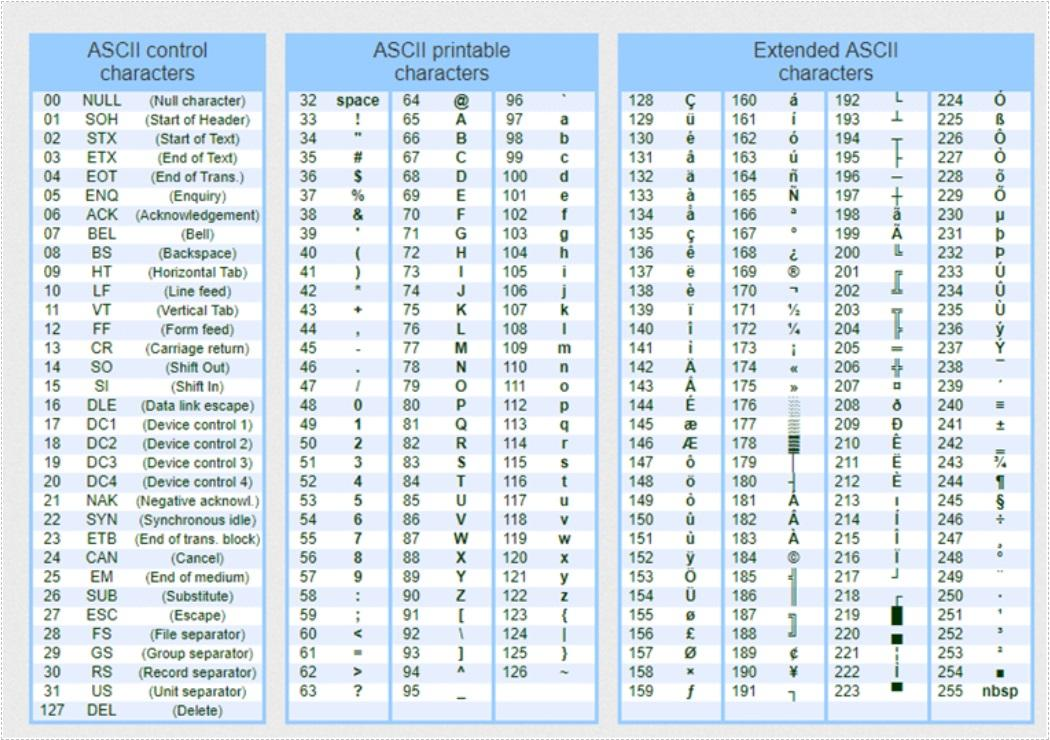

Uma vez que cada caractere $j$ tem um número associado $f(j)$, podemos então criptografar $f(j)$ usando o algoritmo RSA padrão. Assim, ao ler uma mensagem $m$, associamos cada caractere ao seu valor numérico e criamos uma sequência de números criptografados com a chave correspondente, separados por $\_$, conforme o algoritmo abaixo:

1. Recebe uma mensagem (msg) e a chave pública do RSA ($n$ e $e$);
2. Separa a mensagem pelos caracteres e intera sobre cada caractere na mensagem; 
3. Converte o caractere para o valor ASCII usando $ord(carac)$;
4. Eleva o valor ASCII à potência $e$ e calcula o resto da divisão pelo módulo $n$;
5. Une tudo em uma lista $msg\_crip$, junta os resultados da lista, separando-os com "_" e retorna esse valor.

In [4]:
def criptografa(msg, n, e):
    msg_crip = []
    for carac in msg:
        msg_crip.append(str( pow(ord(carac), e, n) ) )
    return "_".join(msg_crip)

## Descriptografador

Ao receber uma mensagem criptografada, separamos os números correpondes a cada caractere e utilizamos a chave privada para descriptografar cada um deles e depois associá-los aos seus respectivos caracteres, conforme o algoritmo a seguir: 

1. Recebe uma mensagem criptografada $(msg\_crip)$ o $n$ e a chave privada $d$;
2. Usa $re.split('\_', msg_crip)$ para obter uma lista de valores criptografados como strings;
3. Converte cada caractere para inteiro e calcula o valor original usando a chave privada d e o módulo n;
4. Então, converte os valores resultantes de volta para caracteres usando $chr(int(carac)^{**}d \ \% \ n)$.
5. Junta os caracteres resultantes em uma mensagem e a retorna.

In [5]:
def descriptografa(msg_crip, n, d):
    msg_crip = re.split('_', msg_crip)
    msg_desc = []
    for carac in msg_crip:
        msg_desc.append( chr( pow(int(carac), d, n) )  )
    return "".join(msg_desc)

## Enviar Email

Tendo esse mecanismo de criptografia, podemos então criar chaves para destinatários e ser capaz de enviar mensagens criptografas por email, por exemplo. O código a seguir demonstra como enviar um e-mail usando o protocolo SMTP (Simple Mail Transfer Protocol) com autenticação SSL. Depois da definição das credencias (remetente, senha e destinatário) e das configurações do e-mail (assunto e corpo), é feita uma conexão SSL segura com o servidor SMTP do Gmail e feito um login no servidor SMTP com as credenciais para, então, enviar um e-mail utilizando o método sendmail e passando o remetente, destinatário e a mensagem formatada como uma string.

In [6]:
def enviar_email(meu_email, senha, email_dest, assunto, texto):
    em = EmailMessage()
    em['From'] = meu_email
    em['To'] = email_dest
    em['subject'] = assunto
    em.set_content(texto)

    context = ssl.create_default_context()

    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp: 
        smtp.login(meu_email, senha)
        smtp.sendmail(meu_email, email_dest, em.as_string())

## Exemplo

Geramos uma chave aleatória de modo que cada primo tenha 2000 bits:

In [11]:
chaves = gera_chaves(2000, True, 1, 1)
print("Chave Pública: ", chaves["chave_pub"])
print("Chave Privada: ", chaves["chave_priv"])

Chave Pública:  (72523710345051088185678503685841473605576754166396105472073677139144944681600818826293576802265182218187615918371899102286255115940827539164367176535233886279986629438727063466681249942052258597016770707216250998118398592541385559890379886835919229694526964347836891302568595953660005206777282181194963566344735482952513800475669993147460620743736010573498014155553259464952193496448304060616567322893535350696737403701130234815280353695041269672642572503492688843642947174897256928170811330314124542045179485664993178727797370360706704693673386850542238940575908401252983234975763392854651567121943364139003629778859632225123609343395857365749063845781657249981228821737310874242849034666195336408740466421742413491435110488503815251207068906443746574796408611142917874598841210413742789170851672532424671395674789131176495135119754603392238587322581901101224994547961965327809857923363614902412387593799852804877598373713828264646817894855388472303721017178464245276285436166484701

Escrevemos uma mensagem de teste, criptografamos e enviamos ao destinatário:

In [12]:
assunto = "Teste 1"
msg = "Funcionou"

msg_crip = criptografa(msg, chaves["chave_pub"][0], chaves["chave_pub"][1])

meu_email = "ezequiel.braga.santos@gmail.com"

enviar_email(meu_email, senha, "ezequielsantos2306@gmail.com", assunto, msg_crip)

In [15]:
print(msg_crip)

3129202661403359008458118539856782628054466067852230202071028990489414096128385615606922501208362110645376039373128584985083485615577781077780923967864804186637737293471640602409576791701932802453756947434466137986561703980007912465996711341333913332351902108095257558030899928710615868929976191026490597129604769665454047523565463455673421817697779602792085481428213291281953292027464326629889661130571901875704102089627646610372454829182446596098710720936774622282655090778062106107928526486798525291932754381664334856401467132557937325470664626409980622833631768171555919195012853959635178685604284178684049882684820569072377633508293752384475183275797373862364960832237966175745001186711157450553896712069227408664926194628798120791688530670445321154234643335586801472503382279757341251983430597673624418554553381222215062365865834717770931518843720572141579059443830800971201214897523068303301202255256070832904129372933655322332946090543876648155239958512468235917586749824949034861404084849913

O que resulta na seguinte mensagem criptografada:

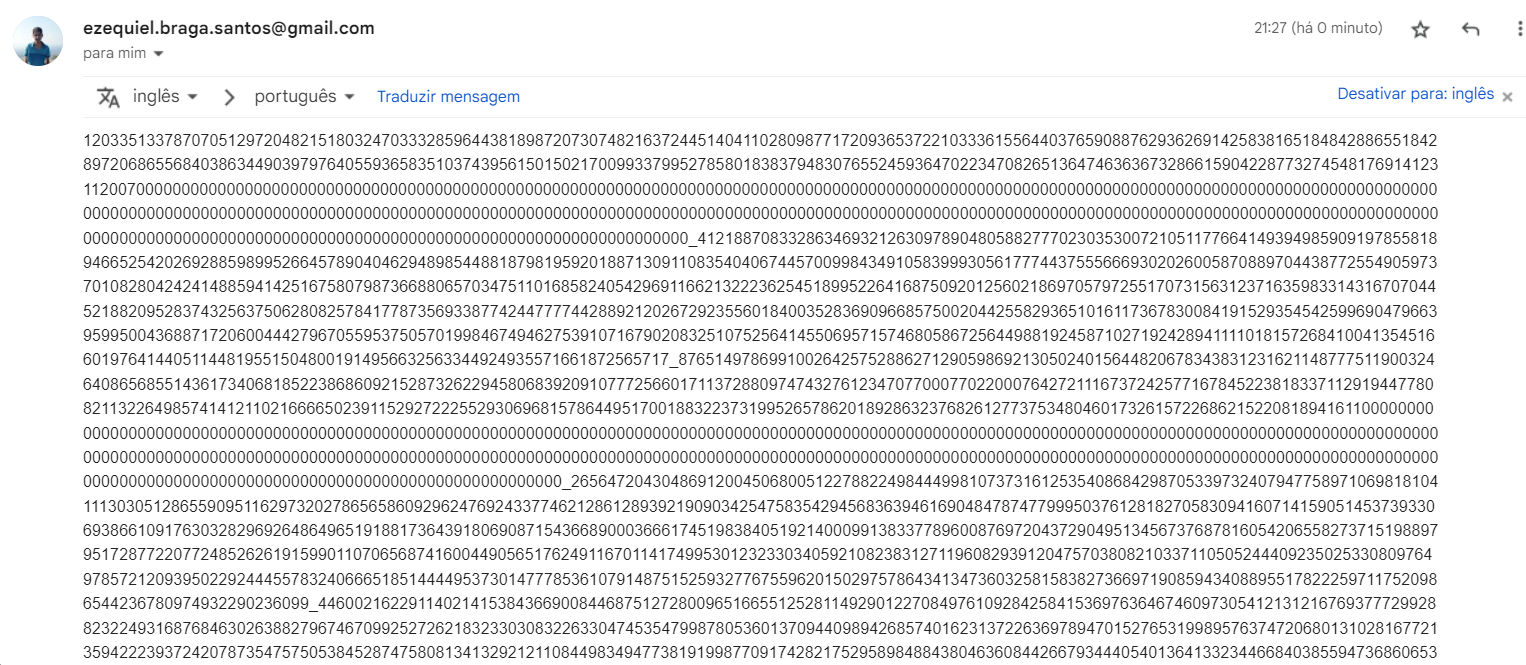

Para descriptografar, basta usar a chave privada:

In [14]:
print(descriptografa(msg_crip, chaves["chave_pub"][0], chaves["chave_priv"]))

Funcionou


# Exemplos frágeis (mais detalhes com Nicole e Wendell)

## Exemplo 1: Mesma mensagem para dois destinatários, com mesmo $n$ e $e$ diferentes.

Geramos duas chaves com os mesmos $p$ e $q$:

In [65]:
p = 63766910589943848817516684764050985137910621947732164629475388409046522314794905759465647958409951362831141983869503244849273872214990010731330618946387560572794317847695155751201241129476433902438038501865691773989427420147148427985070135119122806818254971043136784320830559367279237586874022722142538184716347027621220215837645662441761466466811383355009819196463730971831779427390417679151086498301483917137081615886539812618064029603943011014239971184125969389600764784688648827860103414255996922205859510558013590873613205485403067320460022157708374221374147743310952388749228530917388956235653201
q = 79963723226554798127426292202110513364227236614830738206497846171158814321016491391221738478006200946523250390808893163999246612935771419550109045550709588662780959589728294851590260831936994522317738800807561496219423446408361853097345239967836605060755277580178461518050207583598833546958384210582458518705783716026045839999464453442571605474329849570837530200233366310609850327357710044843514728610475189120767684537981063375550281749501455064803595097168198243089820900566168214931977994165362539033979726070295485545038248327775493778355776870288938347492691528180525449069374243523769277157226129

chaves_11 = {'chave_pub': (5099039589426736068312152210205964889803315716765405028006174572723843321258454088192734222263267270802218394163459290230108064177882872021088100559189910480290290619384329989251220708988278548225856570165244835662118381415754668948062484223499049791578227771495748181756791099920084208414495991819012471943599527860724048145215549587358715140268102519827166540663808510164004759957046492325569921740490567672990252276197791710113769926566736126709030545457082279918344220729768823262956938484253998815987194079242471204601767269825722911136517114489525895088834529139668699763510394839472795253386137548903297938676192703188554777713512981115498836747055305866457164601328212062696170421672033093514740924238890707178957773003413138698679407618707045767914483127482805788909446937405150842637375204325977427154664756078883825214599694073403826760143703045295531111155232176318101574374230428462445073124449497688258823837190465678553916742306877514687850487958292608723921009589131499014274899790396422838799389276600208468428748680656110978513104376884030178337790752770191051783518222510932903933903282469484872933331690551125245551306500491152619221464749268732775626938133417732446086787841579688929,
  473), 'chave_priv': 1573910740076751513686203430634399310594680961200315294056874181009896669986753270351245658457583555046773542384492719605910734397401478467397172688460310634508208098160913696470778485226825936661680886351217222001414976081818565890945291113384484713679537536233359903882645878622267007248449079927221608676037063568003617397888943424427848647947448135084072547435340470367747769458200397208315451530891380296525532415063166151536174226804954491542322324813391147712639019506440271028312289680129141283581670899723891746029298142483204112105563422231439282627843216182646152569709339633325640818169928247685431208959665286900326343523454786322907991608639028761967224781849408314354454294303799397240835114582645539539645122567669104099024043175772118617191810026684955140289622083090625066943988933378660706278231720708859453227971495353218173384581070420965853146306070657823399580677065756921997468978120353131918003761914705646917447635831502559248243123739743769762133680596340392451239814286720398707051156846481540076834465623015506553849610356584336864881275004395217434158785227997273941767163928592000515253998456019771731768331561616493920335573400293184887111579710692331780254253536565061737}

chaves_12 = {'chave_pub': (5099039589426736068312152210205964889803315716765405028006174572723843321258454088192734222263267270802218394163459290230108064177882872021088100559189910480290290619384329989251220708988278548225856570165244835662118381415754668948062484223499049791578227771495748181756791099920084208414495991819012471943599527860724048145215549587358715140268102519827166540663808510164004759957046492325569921740490567672990252276197791710113769926566736126709030545457082279918344220729768823262956938484253998815987194079242471204601767269825722911136517114489525895088834529139668699763510394839472795253386137548903297938676192703188554777713512981115498836747055305866457164601328212062696170421672033093514740924238890707178957773003413138698679407618707045767914483127482805788909446937405150842637375204325977427154664756078883825214599694073403826760143703045295531111155232176318101574374230428462445073124449497688258823837190465678553916742306877514687850487958292608723921009589131499014274899790396422838799389276600208468428748680656110978513104376884030178337790752770191051783518222510932903933903282469484872933331690551125245551306500491152619221464749268732775626938133417732446086787841579688929,
  941),
 'chave_priv': 2552229167502648977869313167913931416681574604247083706897883340863900323392913789095406821132836221623639600054186318489246438074158164422882566804865513109688338875377278878785680078569053343479679537245303206797935980496089743968690148851506963285688996047156745370464876310374452350864216378476891471079102420427631271707116390919921312254055553971135595579864669296798348822465216682131076974643752452044610423827937470664679687178972298316344265023284044371776344450545931047563074089294456571139564259735731353812292701789678975017157597833076053875225123340302639699881629538755995416115138013515235201701961343307262132996005312241868723240319591725100645948193955401077961570982835830005353565642292995801866716836802825804801747437226704612565282073960774419234995872043273541148945181361600877586703035952969602692912576053231595681664340796089805625474891949247826346416534281080491122546193590224853974121323065260420546560323857231702335036669210191258635650122751186450231206669866204930525329930820678212794152335426406355790155312361309946572204191761199683560436992484306382604986782361401537644227443393267529484216326338139310883598911452677249564769183633610191365935272630665236261}

Criamos uma mensagem qualquer e criptografamos com cada uma das chaves públicas:

In [77]:
assunto_1 = "Mesmo n, mesma mensagem"
msg_1 = "duvido você descobrir"

msg_11 = criptografa(msg_1, chaves_11["chave_pub"][0], chaves_11["chave_pub"][1])
msg_12 = criptografa(msg_1, chaves_12["chave_pub"][0], chaves_12["chave_pub"][1])

Enviamos as mensagens para o ataque:

In [80]:
meu_email = "ezequiel.braga.santos@gmail.com"
email_nicole = 'nicoledossantosouza@gmail.com'

texto_11 = "Mensagem 1: \n" + msg_11 + "\n\n" + "Chave pública 1: \n" + str(chaves_11["chave_pub"])
texto_12 = "Mensagem 2: \n" + msg_12 + "\n\n" + "Chave pública 2: \n" + str(chaves_12["chave_pub"])

texto_1 = texto_11 + "\n\n --------------------------------------------------- \n\n" + texto_12

enviar_email(meu_email, senha, email_nicole, assunto_1, texto_1)

## Exemplo 2: Mesma mensagem para três destinatários, $n$ diferentes, mas mesmo $e = 3$.

Criamos uma função que gere chaves com mesmo $e$:

In [54]:
def gera_chaves_mesmo_e(m, e):
    p = 0
    q = 0
    n = 0
    phi = 0
    
    while ((math.gcd(e, phi) != 1) | (p == q)):
        p = number.getPrime(m)
        q = number.getPrime(m)
        n = p * q
        phi = (p - 1) * (q - 1)
    
    d = pow(e, -1, phi)
            
    chave_pub = (n, e)
    chave_priv = d
    return {"chave_pub": chave_pub, "chave_priv": chave_priv}

Geramos 3 chaves com o mesmo $e$:

In [81]:
chaves_21 = {'chave_pub': (7040961268861043878115744931961604431898333306866663273568604114544294092320418997117432928889186642525806728108534891778371080275964290565078882290225184854433995464200189496455930664920227701302920499434123475486002013262365061419927308127993478285201614638540752858265983400917132676288584402383649057623823416118820153748740824649852847578372008569963105487172874894712420806896498246471114573178750217989193412243293537378104732520694415292129117387462695816324061128699098629856859316681118896102009042169196108829071774434372356894077099572827519344142766491570645756070220683924456992197304957791188791793706848636879128556680732953429145528947527848293669913115805177087680183450677128993259733993060454956341952722811251758777185636545105744167047940216347411454064464513391510398334445124766680892368975106421935656624929415517591330586017965623999450327771123123850928893690767648512200733470548873138637456442966210199614603671146941740886794019262193211482029830147836076099901909472374536113993956531010894196703118649362177546135219590554534272927355454711044153357308690496894204995092472298073138167271288771769718880951001758107395943513833352566884766256864007028467643994015487708437,
  3),
 'chave_priv': 4693974179240695918743829954641069621265555537911108849045736076362862728213612664744955285926124428350537818739023261185580720183976193710052588193483456569622663642800126330970620443280151800868613666289415650324001342174910040946618205418662318856801076425693835238843988933944755117525722934922432705082548944079213435832493883099901898385581339046642070324781916596474947204597665497647409715452500145326128941495529024918736488347129610194752744924975130544216040752466065753237906211120745930734672694779464072552714516289581571262718066381885012896095177661047097170713480455949637994798203305082150799001239754779189702173658455103730291620567450720842827965920600783917658339465911883670764751066819942162670464627023346484560765237325009991376520735855246585762772844050984091125328227691689066092741493926347506116631509526611972381231935784376859647027329705054304627586959131235701248898141229682013446673362342678142435416362023620465815264746894198694317520341036492530992296863875825036800994782651552836158191879126542213528846588101985010230206434224793272935888341255018186371232252447265276177338695280565164152595348749290721396134316241878316303258316496260612173085654836525315371}
chaves_22 = {'chave_pub': (7191933985916251651041162066070778486655934041704400325116247008170054361800581042829833574597105895383622679417047489520477478796215343913157275550818395070654463264645618546762688105903644867202079610768397272013854550829586379581445859907359953125285938119868824550719668114654236366235980073555188092638473016495861536844651588881263309777183969946147545243305850875980085597614128799090282809408107369484273364646442058986379337177788056246900439097323493497481804194182056271085690841707038290122090138124157913689689324973305791356855984039553450678549067068963235570500540707621233686174495976449451220263595973680133728891945613501228565556986746436419271022727040304210200310209391262986306624940956584679848240045919009205632208829349538911479697536941049868773149003072088132211353285761831131123261653083895005927686073588197157186720517831702607268951851028608182483754578824106832968397494685803279765828643461060316254112293027049070771800998782205999575350069024794475189964392813602669677463052796107792291547308886457470258231241584195535477781593432909975946422405718051335689282635953001071171516326475935654836855054726023920636373614424234532849554072660494672015973398773738166033,
  3),
 'chave_priv': 4794622657277501100694108044047185657770622694469600216744164672113369574533720695219889049731403930255748452944698326346984985864143562608771517033878930047102975509763745697841792070602429911468053073845598181342569700553057586387630573271573302083523958746579216367146445409769490910823986715703458728425648677663907691229767725920842206518122646630765030162203900583986723731742752532726855206272071579656182243097628039324252891451858704164600292731548995664987869462788037514057127227804692193414726758749438609126459549982203860904570656026368967119032711379308823713667027138414155790782997317519891370119225799603305980516653994179095561491191150762009295415364900018507381720256318959492824586955588452068513415142882969804128541207371829365547231229270236875397010638828328742886026138534557561881338947332226392866663787339836999404768239955976107832191041297158654561367000199057489827467257565043028680116603220847710905315120732911680040148829378120307256144769847548224730141541173991209739754195274419736096826336146377499950162448123965350072311389670242407735576781293265302539864561233520779120821252394114071646344723798846972795919129167755583554205292442468790111983554502053435467}
chaves_23 = {'chave_pub': (7686403440731225488132874179086420881636271431039992235643031805935571760728406972680296178831753752375027651544607199270697974393036249110131289600284283628412290616241255004312709806151275560825768178560435224754222794268115809544788376795473968031866055682467657205383515153664490572436872814574339796327309185842890376769086745418585905899763432416673601177173692144158811188896548994902020000814480548043824085054914812898662962005121818837898896006937943296557742679022879160989982545601887710047604387535599275827373675624231124226267270295661389844781388195207093519901302436949229152445365997500872981441555464385008030899689910429062669537456361182046140394564394931595645575400999758935851368030986877483027381240560056030521499895213465301591596203561306014862889846032603435319097178319015632920006873561618775484061570587003276087214147360025182485264457414615054352482010383870969166645394811804043884949501748057905350006456280743864722925691970141381708373838971473512822053480806199018108526025417721594740211707502686200395509963776270554612977802070049848738829581219997950315473837349744659318053840299902115247407153310569511224491132694699242760037862830478383590781094143238668111,
  3),
 'chave_priv': 5124268960487483658755249452724280587757514287359994823762021203957047840485604648453530785887835834916685101029738132847131982928690832740087526400189522418941527077494170002875139870767517040550512119040290149836148529512077206363192251196982645354577370454978438136922343435776327048291248543049559864218206123895260251179391163612390603933175621611115734118115794762772540792597699329934680000542987032029216056703276541932441974670081212558599264004625295531038495119348586107326655030401258473365069591690399517218249117082820749484178180197107593229854258796804729013267534957966152768296910664883480275897290614704160749618867424503620156036883222015419693249680460018795593412969219786782838760178504778603455257536851222236443406261423380219094139189244750582044728927046978778950833839076653309847473827005384459460068073788694945384811209693451411205818604623863478853558427151787162342256023589126294767942119914197919952958527203475693226283677012027081318936468414848470259699959368101023520062870733027040797854967207837676091305866166360118729486610263968252268664193754930950161018548388881399219265623177931484979406200417740536410777921671599849130038515635412555759199616271845003883}

Criptografamos uma mensagem com cada uma das chaves:

In [84]:
assunto_2 = "Mesmo e, n diferentes"
msg_2 = "agora esse é impossível"

msg_21 = criptografa(msg_2, chaves_21["chave_pub"][0], chaves_21["chave_pub"][1])
msg_22 = criptografa(msg_2, chaves_22["chave_pub"][0], chaves_22["chave_pub"][1])
msg_23 = criptografa(msg_2, chaves_23["chave_pub"][0], chaves_23["chave_pub"][1])

Enviamos a mensagem para ataque:

In [ ]:
texto_21 = "Mensagem 1: \n" + msg_21 + "\n\n" + "Chave pública 1: \n" + str(chaves_21["chave_pub"])
texto_22 = "Mensagem 2: \n" + msg_22 + "\n\n" + "Chave pública 2: \n" + str(chaves_22["chave_pub"])
texto_23 = "Mensagem 3: \n" + msg_23 + "\n\n" + "Chave pública 3: \n" + str(chaves_23["chave_pub"])

texto_2 = texto_21 + "\n\n --------------------------------------------------- \n\n" + texto_22 + "\n\n --------------------------------------------------- \n\n" + texto_23

enviar_email(meu_email, senha, email_nicole, assunto_2, texto_2)

## Exemplo 3 (esse não vai ser quebrado, ainda bem!): Tentativa de fatorar o $n$.

Geramos uma chave aleatória:

In [93]:
chaves_3 = {'chave_pub': (6634966750792990350753484416020635357603867914317493535385412480199281484701352252309704363309938495171413221988594689186459487618766605749496613403326996404358063938927783779052695175479839061994739403258968475024879457929206811800041955325290178427847945146519743887319512332522093262814877366640865764603149604440493266025364425706964645925318856247691432955458853844695539224832499514541423920719718493132784234559266134718121757273624718419818187051258761098736126587427314020146853823227702223903735490027072396564322807058502325445530846963609877699280640737319412850987808166972877344788345978254676470225452653678430176241332118320243766087232011774134568741191646304198829421991922147779102966042673029379257946378932655514771073670767570305714810853311335014331611349066890447518124517992158532056737323075883073487434739812267136226957373183049911849127416629381303051148670814892277011481343363397757834538908333581017319351141763748639438909106210292237329701671553229615888883748050302653927873382930542759662294771781990203833998079664355271791361073512075324041437048087359374431002890094120659766240019733114282717746110688303203287963490750430420484210945259773002597133426275314073349,
  959),
 'chave_priv': 4593970722134041285610337489298959204847725020966439736700640132275623468030967565728512718704691512819414368509308523065494368903921820873478364233377607520848544791916630270376422936932860414144428533643331665710656892664226614218172949255466818014693467755254546341168046077992356544847840011939035315637634345514585535600460874524947366938906903595898969220463690253261562091020625315594896228736072032784326101926332339366874709937108251335515407927044647934891332694527358195388436849450671821347320506129276403877695874751663758181264319482624565998250620906757132568358607531668394741334162387327222485651303211026979721115200030141970879067254267646438746756697451987496184262611889148439789956292434128438829874507341275953783979654834889552499993047908368375453741702332875715499079954069234753395980020440619369908818560424024826030011736087717997477090754635013345821142887073074019102547451059045689555266703160416269762240465588030763056640983978892427771350169832989933169022774518389694635810295149255652428797242371399678996383719886356613756531751967669063701155185835047426325230948648787552072599610963345243577448986420077104665118913636668985981555687644457188582627594563333246495}

Criptogramos e enviamos para o ataque:

In [95]:
assunto_3 = "Chave aleatória"
msg_3 = "álgebra é muito legal"

msg_31 = criptografa(msg_3, chaves_3["chave_pub"][0], chaves_3["chave_pub"][1])

texto_3 = "Mensagem: \n" + msg_31 + "\n\n" + "Chave pública: \n" + str(chaves_3["chave_pub"])

enviar_email(meu_email, senha, email_nicole, assunto_3, texto_3)

## Aguardem os resultados!

Referências:

- GeeksforGeeks. (s.d.). RSA Algorithm in Cryptography. Retirado de https://www.geeksforgeeks.org/rsa-algorithm-cryptography/;
- Wikipedia. (n.d.). RSA (cryptosystem). Retirado de https://en.wikipedia.org/wiki/RSA_(cryptosystem);